# Traditional (10 years ago) 3-layer ANN

## What you'll learn in this lecture
1.  How to add momentum-method weight update to simple ANN
2.  The structure of a standard neural net
3.  Familarization with Cifar data set
4.  How to code a simple ANN for color images

## Order of topics

1.  Upgrade 2-layer ANN to incorporate momentum.
2.  Architecture of standard neural net
3.  Code for MNIST classifier using standard ANN
4.  Introduction to Cifar image classification data set
5.  Coding exercise to build Cifar classifier


## Pre-reading

http://www.cs.toronto.edu/~kriz/cifar.html



## Upgrading 2-Layer Network to Incorporate Momentum-Method Weight Updates

Recall the equations for momentum method from Lecture 2.2.  They're repeated below.

$Step_{i+1} = \beta Step_i - (1 - \beta)\delta\nabla J_i$

and

$w_{i+1} = w_i + Step_{i+1}$

With simple gradient descent you adjust incrementally with gradient information.  With momentum method you introduce a new variable (called "step" in the equation above).  The new variable also gets adjusted incrementally using gradient information and the weights now get adjusted incrementally using the new variable.  Recall that the "update" parameter in the theano function provided the mechanism for incrementally adjusting the weights with the gradient.  You'll have to use that same mechanism for updating the new variable that momentum method introduces.  

The code block below highlights the alterations required to incorporate momentum method updates.  The key difference shows up in the definition of "update".  With pure gradient descent the line of code defining the update previously was:

w.assign(w - gradient * 0.05)

The python list had two components.  The first is the (shared) variable being updated in the function and the second is the new value to be assigned.  If you were doing the updates in python you might author a line something like 

w = w - gradient * 0.05.  

The old definition gets replaced with 

w.assign(w - step)
step.assign(beta * step + (1 - beta) * delta * gradient).  

The first assign() describes the new weight update and the second one describes how the step is updated.  The variable "step" is a new variable introduced by the momentum method.  

## In-class coding exercise
1.  Code momentum method into the 2-layer classifier that you saw in the last lecture.  Extract gradients using the built-in tensorflow tf.gradients() function, construct the extra memory variables that the momentum method requires and code the assign functions to do the updates.  
2.  Use the tensorflow built-in function tf.train.MomentumOptimizer and compare results  
    Hint: tf.train.MomentumOptimizer(learning_rate, momentum).minimize(loss) where learning_rate is the same as before (like 0.1) and momentum is how much you want to keep of the last gradient (like 0.85). You want to minimize the loss. Presumably, this optimizer knows what tf.Variables that can be manipulated, which is the weight vector. Define this optimizer allow with your other tf.Variables and put this optimizer in the session.run. It appears that it returns None instead of something useful (like in W2.assign). For me, it appears that the MomentumOptimizer performs better than our manual momentum updater for some reason.

(400, 1)


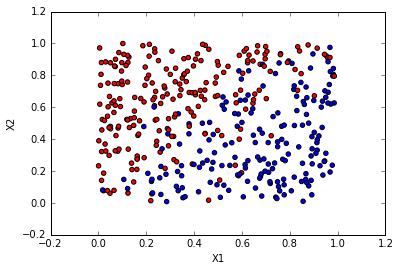

In [1]:
#code for 2-layer classifier network

# Copied from previous lecture -- Data generator
import matplotlib.pyplot as plot
%matplotlib inline
import tensorflow as tf
import numpy as np

sd = 0.2
nRows = 400
X = np.random.uniform(0.0, 1.0, (nRows, 2))
noise = np.random.normal(0.0, sd, nRows)
idx = X[:, 1] > X[:, 0] + noise
Y = np.zeros((nRows, 1))
Y[idx] = 1.0
print Y.shape

colorMap = {0.0: "blue", 1.0: "red"}
colors = [colorMap[c] for c in Y.reshape(-1)]
plot.scatter(X[:, 0], X[:, 1], c=colors)
plot.xlabel("X1")
plot.ylabel("X2")
plot.show()

## The ANN BD (Before Deep Learning)

The figure below shows the basic structure used for neural up until new training approaches were developed in the last 10 years or so.  The network has three layers - input layer, hidden layer and output layer.  Typically the number of hidden neurons is less than the number of input neurons and the number of output neurons is smaller still (dictated largely by the type of problem being solved.  e.g. Binary classification uses two output neurons and MNIST uses 10).  
<img src="files/neural_net.jpeg">



In [1]:
# 3-layer mnist neural net

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
from mnistReader import mnist
from math import sqrt

xTrain, xTest, yTrain, yTest = mnist()


#build and initialize weights
def init_weights(shape, name, glorot=False):
    [n_inputs, n_outputs] = shape
    init_range = sqrt(6.0 / (n_inputs + n_outputs))
    if glorot:
        return tf.Variable(tf.random_uniform(shape, -init_range, init_range), name=name)
    else:
        return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
    
def gdUpdate(W, G, lr): # function not actually used anywhere
    for (w, g) in zip(W, G):
        w.assign(w - lr * g)
    return W[0]


tf.reset_default_graph() 
graph = tf.Graph() 
with graph.as_default():
    X = tf.placeholder(tf.float32, shape=[None, 784])
    Y = tf.placeholder(tf.float32, shape=[None, 10])
    lr = tf.constant(0.02, dtype=tf.float32, name='lr') # if gradients approach infinity, decrease lr
    w1 = init_weights([784, 625], 'w1') # weights between 1st and 2nd layer
    w2 = init_weights([625, 10], 'w2') # weights between 2nd and 3rd layer
    # the second number in w1 (625) is arbitrary. The idea is that the second number is smaller
    # than the first number (784) because you are trying to compress information into fewer
    # feature. For example, you have 784 pixels and you are trying to compress it into 625 numbers
    # before you compress it further into 10 numbers (class prediction probabilities).
    # 3-layer network should work better than 2-layers because 3-layer network allows "slower"
    # learner and more ability to learn the patterns. 
    # Nonetheless, keep in mind we are heavily overfitting in both 2- and 3-layer networks. 
    # In this current form, the 3-layer network has more weights, so it is allowed to 
    # overfit more. This partially examples slightly better accuracy.

    #define network
    # output from 2nd layer: X.dot(w1) is input into 2nd layer, which you apply activation relu
    h1 = tf.nn.relu(tf.matmul(X, w1))  #look under Neural Net -> Activation in API left column
    logits = tf.matmul(h1, w2) # matrix multiply to create input into 3rd layer
    py_x = tf.nn.softmax(logits) # output of 3rd layer
    y_pred = tf.argmax(py_x, dimension=1) # actual prediction, gives the index number that has highest value

    #define cost
    rows_of_cost = tf.nn.softmax_cross_entropy_with_logits(logits, Y, name='rows_of_cost')
    cost = tf.reduce_mean(rows_of_cost, reduction_indices=None, keep_dims=False, name='cost')

    #start building list that you'll reference in sess.run; it will execute cost function, weight updates
    udList = [cost]

    #use hand-crafted updater
    W = [w1, w2]
    #calculate gradients
    grad = tf.gradients(cost, W) # gradient for both weight matricies

    #form a list of the updates - including this in sess.run will force calculation of new weights each step
    udList = udList + [w.assign(w - lr * g) for (w, g) in zip(W, grad)]

    #use tf.optimizer by uncommenting the following two lines (and modifying where necessary)
    #optimizer = tf.train.GradientDescentOptimizer(lr)
    #train = optimizer.minimize(cost)

    #output for tensorboard
    summary1 = tf.scalar_summary("Cost over time", cost) 
    summary2 = tf.histogram_summary('Weight w1 over time', w1)
    summary3 = tf.histogram_summary('Weight w2 over time', w2)
    merged = tf.merge_summary([summary1, summary2, summary3]) 

    #add tensorboard output to sess.run list
    udList.append(merged)

with tf.Session(graph=graph) as sess:
    result = sess.run(tf.initialize_all_variables())
    writer = tf.train.SummaryWriter('logs/',graph=sess.graph)
    miniBatchSize = 40
    startEnd = zip(range(0, len(xTrain), miniBatchSize), range(miniBatchSize, len(xTrain) + 1, miniBatchSize))
    costList = []
    nPasses = 30
    iteration = 0
    for iPass in range(nPasses):
        for (s, e) in startEnd:
            [costVal, update1, update2, tbSummary] = sess.run(udList, feed_dict={X: xTrain[s:e,], Y: yTrain[s:e]})
            writer.add_summary(tbSummary, iteration)
            iteration += 1
            costList.append(costVal)
        if iPass % 5 == 0: 
            testResult = sess.run([y_pred], feed_dict={X:xTest})
            print iPass, np.mean(np.argmax(yTest, axis=1) == testResult)

0 0.8936
5 0.9428
10 0.9608
15 0.9686
20 0.9724
25 0.9751


## In-Class coding exercises

1.  Change to Glorot, Bengio initial weights and tanh non-linearities and rerun.  You can make those changes by  uncommenting the code above
2.  Pick a configuration and switch to AdaGrad, AdaDelta or NAG updates (keeping Glorot, Bengio initial wts).  What is the difference?
3.  Add dropout to the hidden layer and try training with some different values of keep_prob

## CIFAR data set - processing full color images

Here's a link to the web page where you can download the Cifar image classification images.  You'll build a neural net to classifiy the Cifar-10 images.  This data set has 60,000 32x32 pixel images containing 10 different classes.  The data set is balanced.  It contains 6000 of each of the 10 classes.  The data are divided into 50,000 training examples and 10,000 test examples.  The 10 classes are - airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.  The image below shows several examples.  
<img src="CifarImages.png">

The code below reads the training and test data sets.  You'll only train on 10,000 of the training examples in order to cut down on the training time.  



In [3]:
from cifarHandler import cifar

xTrain, yTrain, xTest, yTest = cifar()


print 'xTrain shape = ', xTrain.shape
print 'yTrain shape = ', yTrain.shape
print 'xTest shape = ', xTest.shape
print 'yTest shape = ', yTest.shape

xTrain shape =  (10000, 3072)
yTrain shape =  (10000, 10)
xTest shape =  (10000, 3072)
yTest shape =  (10000, 10)


This is the 1 hot coding for this picture:  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


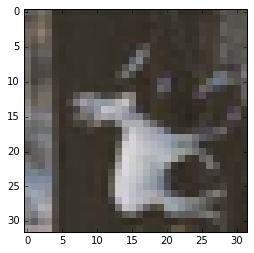

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(xTrain[20].reshape(3, 32, 32).T, interpolation='nearest')
print "This is the 1 hot coding for this picture: ", yTrain[20]

## Q's

1.  There are 10000 rows of x's and y's for training and for testing.  Explain the other dimension of the xTrain and xTest arrays.  

## In-class coding exercise

Adapt the 2-layer MNIST code from last lecture to train a classifier for the cifar images.  

In [5]:
# copy code from 2-layer MNIST lecture and adapt to Cifar
# Hint: remember to import from cifarHandler instead of mnistreader
# Hint: cifar images are larger (32 by 32 by 3) than mnist. 
# Hence the weight matrix shape will be 3072 by 10.
# Hint: if gradients become too large (ie TensorFlow says that tbSummary
# goes to nan), then decrease learning rate.
# Hint: if accuracy goes up and then falls down, then decrease learning rate.
# Hint: if it accuracy still goes down, you can change to high-performance gradient
# descent. Just getting the code to run is sufficient.

## Homework exercise
Code a standard 3 layer ANN for classifying Cifar images. Copy the MNIST code above in this lecture and modify it for Cifar. What's the primary difference between this homework exercise and the above in-class coding exercise? The answer is that we are really just adding 1 layer in between input and output layer.  

In [1]:
# copy above code from this lecture 
# Hint: if will take over an hour to train since there are over 1 million weights
# so you can decrease the weight matrix size from 625 to something smaller.
# Nonetheless, it will still take a long time. If you want to speed it up,
# you can use the test set instead of the training set since test set is smaller.
# In this case, print the accuracy using the training set instead of test set for every 5 epochs.
# In any case, if your code runs, then the goal is met.